In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the data 
delay_df = pd.read_csv('Toronto-Subway-Delay-Jan-2014-Jun-2021.csv')
code_df = pd.read_csv('Toronto-Subway-Delay-Codes.csv')

The goal of analyzing this data set is to determine whether we can predict your subway delay times

# DATA CLEANING AND WRANGLING

In [5]:
# view data set
delay_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014/01/01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014/01/01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014/01/01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014/01/01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014/01/01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


In [117]:
delay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143917 entries, 0 to 143916
Data columns (total 10 columns):
Date         143917 non-null object
Time         143917 non-null object
Day          143917 non-null object
Station      143917 non-null object
Code         143916 non-null object
Min Delay    143917 non-null int64
Min Gap      143917 non-null int64
Bound        111703 non-null object
Line         143373 non-null object
Vehicle      143917 non-null int64
dtypes: int64(3), object(7)
memory usage: 11.0+ MB


Dataset contains date, time and day of the subway delay, station it occurs at, code of the delay, the direction the subway is bound in, the line the subway is on and the vehicle number

In [19]:
# view codes dataset
code_df.head()

,Code #,RMENU CODE,Vehicle Type,CODE DESCRIPTION
0,1,EUAC,SUB,Air Conditioning
1,2,EUAL,SUB,Alternating Current
2,3,EUATC,SUB,ATC RC&S Equipment
3,4,EUBK,SUB,Brakes
4,5,EUBO,SUB,Body


Dataset contains codes for delay types, description for what the delay is and the type of vehicle it occured in 

In [26]:
# rename the column in code_df so that merge can be performed
code_df.rename(columns = {'RMENU CODE': "Code"}, inplace = True)

In [315]:
# merge the df containing delays and code data 

big_df = pd.merge(delay_df, code_df, how = "left", on = "Code")

In [316]:
# view if merge was done correctly
big_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,CODE DESCRIPTION
0,2014/01/01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,52.0,SUB,Priority One - Train in Contact With Person
1,2014/01/01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,105.0,SUB,Disorderly Patron
2,2014/01/01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,NaN,NaN,NaN
3,2014/01/01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,105.0,SUB,Disorderly Patron
4,2014/01/01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,53.0,SUB,Unsanitary Vehicle


As we are only interested in subway data drop the street car data

In [623]:
big_df = big_df[big_df['Vehicle Type'] == "SUB"]

# Dealing with Missing Data

In [317]:
# look at basic info of data frame
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143917 entries, 0 to 143916
Data columns (total 13 columns):
Date                143917 non-null object
Time                143917 non-null object
Day                 143917 non-null object
Station             143917 non-null object
Code                143916 non-null object
Min Delay           143917 non-null int64
Min Gap             143917 non-null int64
Bound               111703 non-null object
Line                143373 non-null object
Vehicle             143917 non-null int64
Code #              140859 non-null float64
Vehicle Type        140859 non-null object
CODE DESCRIPTION    140859 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 15.4+ MB


In [318]:
# check for nulls in data 
big_df.isnull().sum()

Date                    0
Time                    0
Day                     0
Station                 0
Code                    1
Min Delay               0
Min Gap                 0
Bound               32214
Line                  544
Vehicle                 0
Code #               3058
Vehicle Type         3058
CODE DESCRIPTION     3058
dtype: int64

There are nulls present in the Bound column (indicating direction of subway), Line Column, Vechicle type, Code # and Code Description

View the meaning of the blanks in the dataset

In [319]:
# Determine the number of missing values 
for col in big_df.columns:
    missing = big_df[col].isna().sum()
    percent = missing / big_df.shape[0] * 100
    print("%s: %.2f%% (%d)" % (col,percent,missing))

Date: 0.00% (0)
Time: 0.00% (0)
Day: 0.00% (0)
Station: 0.00% (0)
Code: 0.00% (1)
Min Delay: 0.00% (0)
Min Gap: 0.00% (0)
Bound: 22.38% (32214)
Line: 0.38% (544)
Vehicle: 0.00% (0)
Code #: 2.12% (3058)
Vehicle Type: 2.12% (3058)
CODE DESCRIPTION: 2.12% (3058)


As the blanks in Bound consist of 22.38% of the total data, these will be filled in with the mode of the column

In [320]:
big_df['Bound'] = big_df['Bound'].fillna(value = big_df['Bound'].mode()[0], axis = 0, )

Seeing as the Line, Code, Vehicle Type and CODE DESCRIPTION columns blanks ony consist of <3% of the total data, these will be dropped 

In [321]:
big_df.dropna(how = "any", inplace = True)

In [322]:
# check the blanks of the data 
big_df.isnull().sum()

Date                0
Time                0
Day                 0
Station             0
Code                0
Min Delay           0
Min Gap             0
Bound               0
Line                0
Vehicle             0
Code #              0
Vehicle Type        0
CODE DESCRIPTION    0
dtype: int64

# Dealing with Outliers

In [631]:
# examine the range in the Delay Time
big_df['Min Delay'].describe()

count    135161.000000
mean          2.098771
std           7.556439
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         575.000000
Name: Min Delay, dtype: float64

Examining the range above, to conduct a proper assessment of delay times, outliers from the data must be removed, as including the extremes will skew the mean delay times which will be calculated later 

In [879]:
Q

7.5

In [632]:
# calculate quartiles of data 
Q1 = big_df['Min Delay'].quantile(0.25)
Q3 = big_df['Min Delay'].quantile(0.75)

In [633]:
# calculate interquartile range of data 
IQR = Q3- Q1

In [634]:
# remove data that is greater Q3 + 1.5* IQR and less than Q1 - 1.5 * IQR 
big_df = big_df.drop(index = big_df[(big_df['Min Delay']< (Q1 - IQR*1.5)) | (big_df['Min Delay'] > (Q3 + 1.5 * IQR))].index)

# View DataFrame
big_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,Code Description,Datetime,Hour,Count,Month
1,2014-01-01,02:06,2,HIGH PARK STATION,SUDP,3,7,W,BD,5001,105.0,SUB,DISORDERLY PATRON,2014-01-01 02:06:00-05:00,2,1,1
2,2014-01-01,03:10,2,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,105.0,SUB,DISORDERLY PATRON,2014-01-01 03:10:00-05:00,3,1,1
3,2014-01-01,03:20,2,BLOOR STATION,MUSAN,5,10,S,YU,5386,53.0,SUB,UNSANITARY VEHICLE,2014-01-01 03:20:00-05:00,3,1,1
4,2014-01-01,03:29,2,DUFFERIN STATION,MUPAA,0,0,E,BD,5174,48.0,SUB,PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROU...,2014-01-01 03:29:00-05:00,3,1,1
5,2014-01-01,08:48,2,KIPLING STATION,MUNOA,5,0,E,BD,0,45.0,SUB,NO OPERATOR IMMEDIATELY AVAILABLE - NOT E.S.A....,2014-01-01 08:48:00-05:00,8,1,1


In [748]:
# Bound column should only have directions, check if this is true 
big_df['Bound'].unique()

array(['W', 'S', 'E', 'N', 'B', '0'], dtype=object)

It doesnt make sense to have B or 0 direction, lets look at the occurences of this 

In [749]:
big_df['Bound'].value_counts()

S    44143
W    26226
E    24468
N    21147
B        8
0        1
Name: Bound, dtype: int64

In [750]:
# as there is only 8 B values and 1 0 values while the other directions are much greater, it is very probable that these are errors
big_df.drop(big_df[(big_df['Bound'] == "B")|(big_df['Bound'] == "0")].index, inplace = True)

# Covert Date Times to Pandas Date Time Object

In [371]:
# set the date column as a datetime object
big_df['Date'] = pd.to_datetime(big_df['Date'])

In [337]:
# create merged Date Time Column 
big_df['Datetime'] = big_df['Date'] + " " + big_df['Time']

In [338]:
# plot subway delays throughout time 
big_df['Datetime'] = pd.to_datetime(big_df['Datetime'])

In [339]:
# import pytz package 
import pytz

In [340]:
# localize timezone to EST (Toronto Timezone)
# declare eastern time stamp variable to use in for loop 
est = pytz.timezone('Canada/Eastern')

# Apply the EST timezone to all date times in index column 
big_df['Datetime'] = big_df.apply(lambda row: est.localize(row['Datetime']), axis = 1)

In [349]:
# create hour column which will be used in plots later
big_df['Hour'] = big_df.index.hour 

In [385]:
# create month column which will be used in plots later 
big_df['Month'] = big_df['Datetime'].dt.month

In [566]:
# make day column a datetime object
big_df['Day'] = big_df['Date'].dt.dayofweek

# Make sure all data is consistent

In [562]:
# upper case all data in columns such that its consistent throughout
big_df['CODE DESCRIPTION'] = big_df['CODE DESCRIPTION'].str.upper()

In [365]:
# Fix title of column names 
big_df.rename(columns = {"CODE DESCRIPTION":"Code Description"}, inplace = True)

In [380]:
# create another column called "Count" with values of 1 for later data aggregation
big_df['Count'] = 1

We only want to account for delays that occur at subway stations

In [658]:
# only include stations that end with STATION which indicates subway station
big_df = big_df[big_df['Station'].str.endswith(" STATION")]

In [659]:
# take a look at the unique stations 
big_df['Station'].unique()

array(['HIGH PARK STATION', 'LANSDOWNE STATION', 'BLOOR STATION',
       'DUFFERIN STATION', 'KIPLING STATION', 'YONGE SHP STATION',
       'ST PATRICK STATION', 'KENNEDY BD STATION', 'JANE STATION',
       'OLD MILL STATION', 'SHEPPARD WEST STATION', 'BAY STATION',
       'FINCH STATION', 'COXWELL STATION', 'ST CLAIR WEST STATION',
       'QUEEN STATION', 'DUPONT STATION', 'YORK MILLS STATION',
       'DUNDAS WEST STATION', 'OSGOODE STATION', 'COLLEGE STATION',
       'VICTORIA PARK STATION', 'ST GEORGE YUS STATION',
       'EGLINTON STATION', 'BROADVIEW STATION', 'ROSEDALE STATION',
       'PAPE STATION', 'GREENWOOD STATION', 'ISLINGTON STATION',
       'WARDEN STATION', 'NORTH YORK CTR STATION', 'LAWRENCE STATION',
       'EGLINTON WEST STATION', 'KEELE STATION', 'UNION STATION',
       'CHESTER STATION', 'GLENCAIRN STATION', 'WILSON STATION',
       'DAVISVILLE STATION', 'YORKDALE STATION', 'MUSEUM STATION',
       'RUNNYMEDE STATION', 'SHEPPARD STATION', 'DUNDAS STATION',
       '

In [670]:
# It is clear that are several missing spellings for several stations so this must be replaced 
misspelled = {'ST GEORGE YU STATION': "ST.GEORGE STATION", 'ST GEORGE YUS STATION':"ST.GEORGE STATION", "FICNH STATION": "FINCH STATION", "KILPING STATION": "KIPLING STATION", 'YONGE SHEPPARD STATION':'YONGE SHP STATION', 'SHEPPARD/YONGE STATION':'YONGE SHP STATION', 'SHEPPARD-YONGE STATION': "YONGE SHP STATION", 'YONGE SHEP STATION':"YONGE SHP STATION", "ST CALIR STATION": "ST CLAIR STATION", 'BAY LOWER STATION': "BAY STATION", "DOWNSVIEW STATION": 'SHEPPARD WEST STATION', 'BATHUSRT STATION': "BATHURST STATION", 'LANSDOWN STATION': "LANSDOWNE STATION", 'LAWERENCE STATION':"LAWRENCE STATION", "DOWNSVIEW PARK STATION": 'SHEPPARD WEST STATION'}


In [671]:
big_df = big_df.replace({"Station": misspelled})

In [675]:
# some stations still contain line in station such as BD, YU, SUB, SRT, YUS
big_df['Station'] = big_df['Station'].str.replace("BD ", "")
big_df['Station'] = big_df['Station'].str.replace("YU ", "")
big_df['Station'] = big_df['Station'].str.replace("SUB ", "")
big_df['Station'] = big_df['Station'].str.replace("SRT ", "")
big_df['Station'] = big_df['Station'].str.replace("YUS ", "")

In [676]:
big_df['Station'].unique()

array(['HIGH PARK STATION', 'LANSDOWNE STATION', 'BLOOR STATION',
       'DUFFERIN STATION', 'KIPLING STATION', 'YONGE SHP STATION',
       'ST PATRICK STATION', 'KENNEDY STATION', 'JANE STATION',
       'OLD MILL STATION', 'SHEPPARD WEST STATION', 'BAY STATION',
       'FINCH STATION', 'COXWELL STATION', 'ST CLAIR WEST STATION',
       'QUEEN STATION', 'DUPONT STATION', 'YORK MILLS STATION',
       'DUNDAS WEST STATION', 'OSGOODE STATION', 'COLLEGE STATION',
       'VICTORIA PARK STATION', 'ST.GEORGE STATION', 'EGLINTON STATION',
       'BROADVIEW STATION', 'ROSEDALE STATION', 'PAPE STATION',
       'GREENWOOD STATION', 'ISLINGTON STATION', 'WARDEN STATION',
       'NORTH YORK CTR STATION', 'LAWRENCE STATION',
       'EGLINTON WEST STATION', 'KEELE STATION', 'UNION STATION',
       'CHESTER STATION', 'GLENCAIRN STATION', 'WILSON STATION',
       'DAVISVILLE STATION', 'YORKDALE STATION', 'MUSEUM STATION',
       'RUNNYMEDE STATION', 'SHEPPARD STATION', 'DUNDAS STATION',
       'SHERBOU

# Exploratory Data Analysis

<Figure size 1080x360 with 0 Axes>

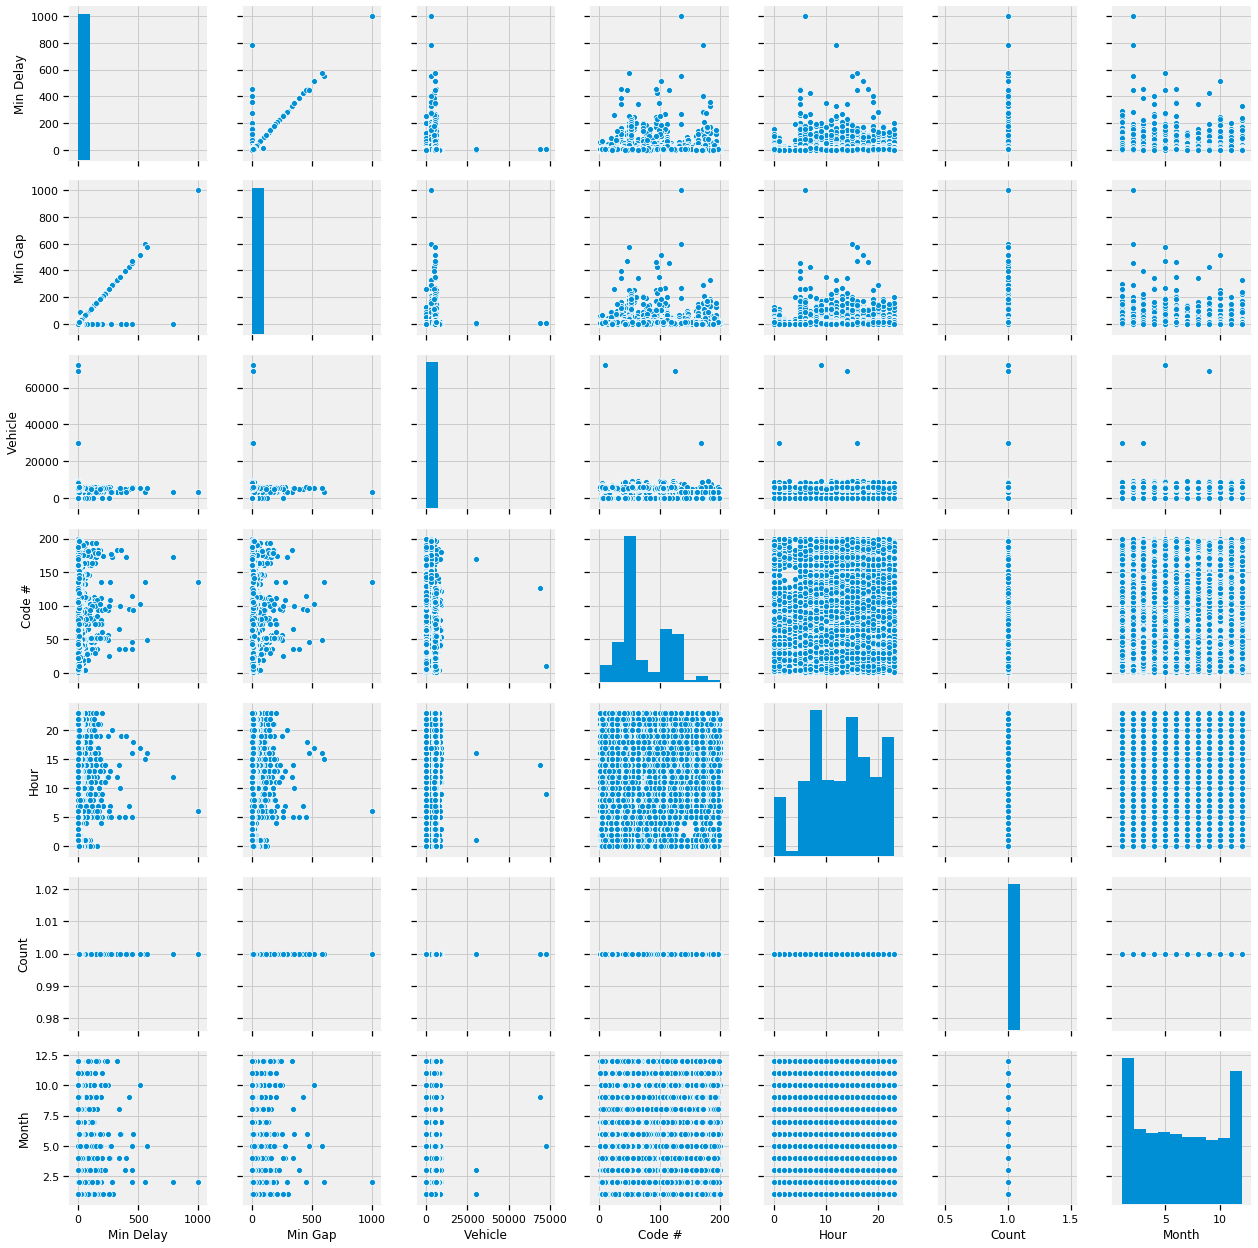

In [459]:
# Create a pairwise plot to determine what values are correlated by creating PairWise Plots
plt.figure(figsize = (15,5))
sns.pairplot(big_df)

# Temporal Analysis

What did delays look like throughout the year? What was the impact of lockdown on subway delays?

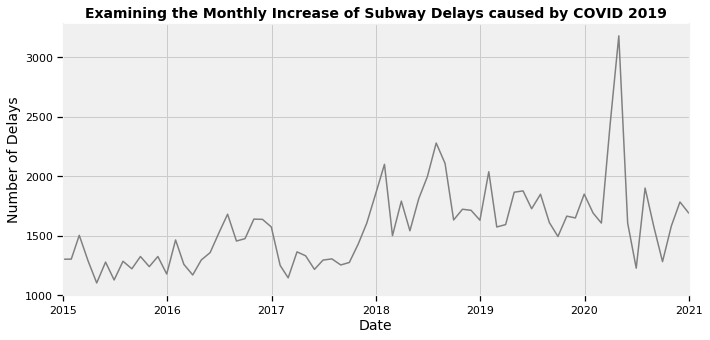

In [766]:
#TimeSeries plot of subway delays throughout the years 

plt.figure(figsize = (10,5))
sns.lineplot(x = big_df.set_index("Date").resample("m").sum().index, y = big_df.set_index("Date").resample("m").sum()['Min Delay'], color = "grey")
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Number of Delays", fontsize = 14)
plt.xlim("2015","2021")
plt.title("Examining the Monthly Increase of Subway Delays caused by COVID 2019", fontsize = 14, weight = "bold")
plt.savefig("Monthly Effect of COVID 19")

Examining the plot above, it appears that there is a greater amount of subway delays due to COVID 19, however average out yearly data to be sure 

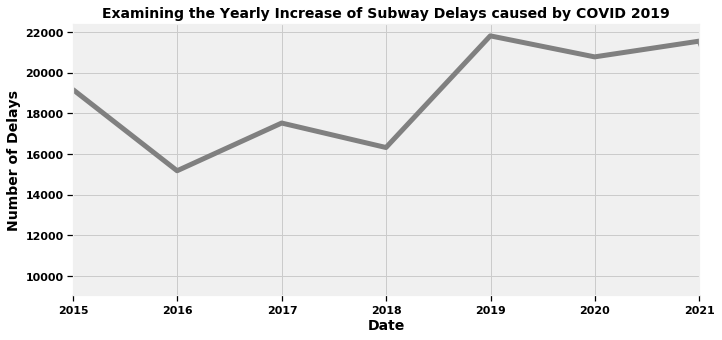

In [804]:
#TimeSeries plot of subway delays throughout the years 

plt.figure(figsize = (10,5))
sns.lineplot(x = big_df.set_index("Date").resample("y").sum().index, y = big_df.set_index("Date").resample("y").sum()['Min Delay'], color = "grey", linewidth = 5)
plt.xlabel("Date", fontsize = 14, weight = "bold")
plt.ylabel("Number of Delays", fontsize = 14, weight = "bold")
plt.xlim("2015","2021")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Yearly Increase of Subway Delays caused by COVID 2019", fontsize = 14, weight = "bold")
plt.savefig("Yearly Effect of COVID 19")

Looking at yearly average subway delays, the year of the pandemic, 2020, and 2021 appear higher than the previous year, although not as high as in 2019, could this be because of the pandemic and less staff employed?

Upon further investigation: The TTC laid of 1200 employees in April 2020 https://www.cbc.ca/news/canada/toronto/ttc-layoffs-1.5542445
https://globalnews.ca/news/6857983/coronavirus-ttc-layoffs/

All employees who were not able to meet their vaccination status were fired in 2021: 
https://globalnews.ca/news/8269099/ttc-terminate-employees-covid-vaccination-policy/

Why was there a sudden peak/increase in the number of delays in 2019? Article was found discussing complaining Torontonians on the amount of subway delays experienced this particular year. https://toronto.citynews.ca/2020/01/03/ttc-delays-2019/
Article sources the amount of delays this year to be predominantly because of signal problems, rail issues, weather-related issues, unauthorized people on track levels, fires and so on.

In [769]:
# determine the top 10 reasons for subway delays the occured in 2019 
big_df[(big_df['Date'].dt.year == 2019)]['Code Description'].value_counts().head(10)

MISCELLANEOUS SPEED CONTROL                                   1965
INJURED OR ILL CUSTOMER (IN STATION) - TRANSPORTED            1714
OPERATOR OVERSPEEDING                                         1369
PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND       1319
DISORDERLY PATRON                                             1025
INJURED OR ILL CUSTOMER (ON TRAIN) - MEDICAL AID REFUSED       592
ESCALATOR/ELEVATOR INCIDENT                                    583
SPEED CONTROL EQUIPMENT                                        511
INJURED OR ILL CUSTOMER (IN STATION) - MEDICAL AID REFUSED     432
OPERATOR VIOLATED SIGNAL                                       430
Name: Code Description, dtype: int64

Half of the top 10 reasons for signal delays in 2019 were because of passenger issues. During the pandemic where there were less passengers on board due to the work from home mandate, what were the top 10 reasons for delays then? 

In [773]:
# determine the top 10 reasons for subway delays the occured in 2020 and 2021
big_df[(big_df['Date'].dt.year == 2020) | (big_df['Date'].dt.year == 2021)]['Code Description'].value_counts().head(10)

DISORDERLY PATRON                                             2129
INJURED OR ILL CUSTOMER (IN STATION) - TRANSPORTED            1975
NO OPERATOR IMMEDIATELY AVAILABLE - NOT E.S.A. RELATED        1278
PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND       1273
MISCELLANEOUS SPEED CONTROL                                    907
INJURED OR ILL CUSTOMER (IN STATION) - MEDICAL AID REFUSED     674
OPERATOR OVERSPEEDING                                          642
PASSENGER OTHER                                                575
OPERATOR VIOLATED SIGNAL                                       553
ATC PROJECT                                                    497
Name: Code Description, dtype: int64

Interesting to note that during the pandemic, the top third reason that was not found in the previous year for delays is "No Opereator Immediately Available - Not E.S.A Related" which could be due to the layoff of employees from the corporation 
It is also interesting to note that the #1 reason for delays during the pandemic years are disorderly customers and in the top 10 are unauthorized customers at the track level
The COVID-19 panemic and recession has adversely affected many people's mental health. During the pandemic,it was discovered that 4 in 10 adults have reported symptoms of anxeity or depressive disorder.
https://www.kff.org/coronavirus-covid-19/issue-brief/the-implications-of-covid-19-for-mental-health-and-substance-use/

Determine the average delays per month, i.e. what month experiences the most delays, it is hypothesized that there will be more subway delays in the winter time because of signal issues due to freezing months and less in the summer months because less people riding

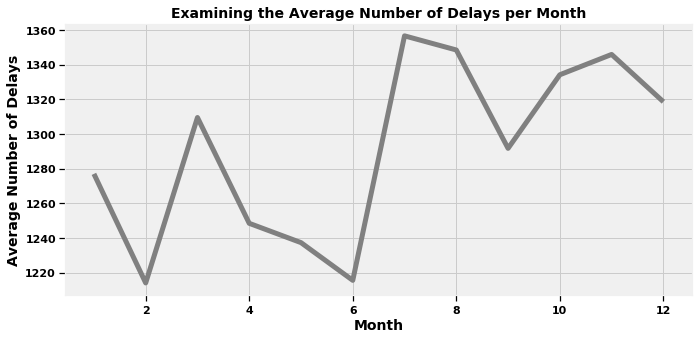

In [808]:
plt.figure(figsize = (10,5))
ax = sns.lineplot(x =big_df.groupby([big_df['Datetime'].dt.year,"Month"]).sum().groupby("Month").mean()['Count'].index, y= big_df.groupby([big_df['Datetime'].dt.year,"Month"]).sum().groupby("Month").mean()['Count'], color = "grey", linewidth = 5)
plt.xlabel("Month", fontsize = 14, weight = "bold")
plt.ylabel("Average Number of Delays", fontsize = 14, weight = "bold")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Average Number of Delays per Month", fontsize = 14, weight = "bold")
plt.savefig("Average Delays by month")

Why is there peak amount of delays in July and August, but right before the minimum that occurs in June? Typically there is a lack of air conditioning on transit during the summer months, which can cause more heat induced illness during the hotter months. 
https://www.narcity.com/toronto/ttc-commuters-are-so-over-this-summers-heat-and-delays

What is the probability of experiencing a delay in one month vs the next? 

In [476]:
# determine the average amount of delays per year 
ann_delay_mean = big_df.groupby(big_df['Datetime'].dt.year).sum()['Count'].mean()

In [477]:
month_prob = big_df.groupby([big_df['Datetime'].dt.year,"Month"]).sum().groupby("Month").mean()['Count']/ann_delay_mean*100

In [777]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

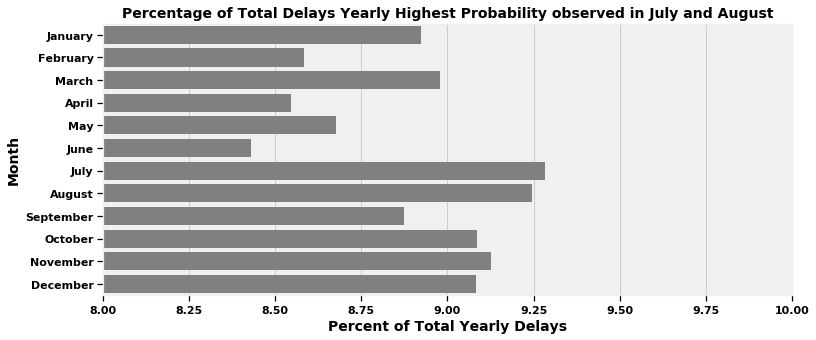

In [801]:
plt.figure(figsize = (11,5))
ax = sns.barplot(y =months, x = month_prob.values, color = "gray", orient = "h")
plt.xlabel("Percent of Total Yearly Delays", fontsize = 14, weight = "bold")
plt.ylabel("Month", fontsize = 14, weight = "bold")
plt.xlim([8,10])
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Percentage of Total Delays Yearly Highest Probability observed in July and August", fontsize = 14, weight = "bold")
plt.savefig("Average Delays by month - percentage")

Examine the delay by day of the week: hypothesized that there are more delays during the week than there would be during the weekend

Examine the delays by hour of the day: hypothesized that there will be a higher amount of delays during rush hour where there are more customers, more likely to cause customer related delays 

In [511]:
# determine the average amount of delays per day 
avg_delays_day = big_df.groupby("Date").sum()['Count'].mean()

In [516]:
# determine the percent of total delays per day for that hour
average_hourly_delay = big_df.groupby(["Date","Hour"]).sum().groupby("Hour").mean()['Count']/avg_delays_day*100

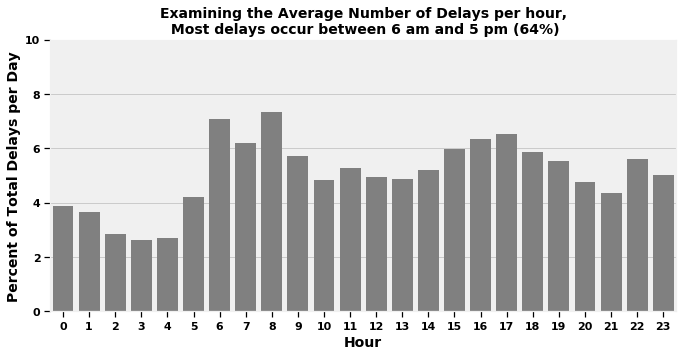

In [800]:
plt.figure(figsize = (10,5))
ax = sns.barplot(x =average_hourly_delay.index, y = average_hourly_delay.values, color = "gray")
plt.ylim([0,10])
plt.xlabel("Hour", fontsize = 14, weight = "bold")
plt.ylabel("Percent of Total Delays per Day", fontsize = 14, weight = "bold")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Average Number of Delays per hour,\n Most delays occur between 6 am and 5 pm (64%)", fontsize = 14, weight = "bold")
plt.savefig("Percent of delays per hour")

In [532]:
# what percentage of delays occur between 6 am and 5pm?
average_hourly_delay[6:17].values.sum()

63.75263503033473

64% of delays occur in between 6 am and 5pm (during work hours) depsite taking up less than half the day

What do delays look like throughout the week? It is expected that there will be a higher amount of delays during the work week since they are more commuters, leading to customer related delays 

In [588]:
# What are the total number of delays per week ?
total_delays_weekly = big_df.groupby(['Date','Day']).sum().groupby("Day").mean()['Count'].sum()

In [595]:
# What do delays look like on weekdays compared to weekends? where 0 represents monday and 6 represents sunday
dayofweek_delays = big_df.groupby(["Date", "Day"]).sum().groupby("Day").mean()['Count']/total_delays_weekly*100

In [794]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

<Figure size 720x360 with 0 Axes>

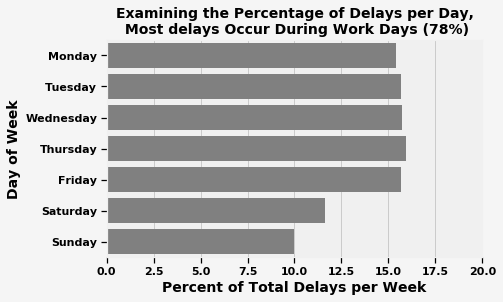

In [1001]:
plt.figure(figsize = (10,5))
plt.figure(facecolor="whitesmoke") 
sns.barplot(y =days, x = dayofweek_delays.values, color = "gray", orient = "h")
plt.xlim([0,20])
plt.ylabel("Day of Week", fontsize = 14, weight = "bold")
plt.xlabel("Percent of Total Delays per Week", fontsize = 14, weight = "bold")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Percentage of Delays per Day,\n Most delays Occur During Work Days (78%)", fontsize = 14, weight = "bold")
plt.savefig("Percent of delays per day of week")

It is as expected that most delays (78%) would occur during the week day 

# Impact of Location

Which stations are experiencing the most delays? It is hypothesized that the the stations that connect lines such as St.George, Spadina, Bloor-Yonge will experience the highest amounts of delays as they are typically the busiest

In [602]:
big_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,Code Description,Datetime,Hour,Count,Month
0,2014-01-01,00:21,2,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,52.0,SUB,PRIORITY ONE - TRAIN IN CONTACT WITH PERSON,2014-01-01 00:21:00-05:00,0,1,1
1,2014-01-01,02:06,2,HIGH PARK STATION,SUDP,3,7,W,BD,5001,105.0,SUB,DISORDERLY PATRON,2014-01-01 02:06:00-05:00,2,1,1
2,2014-01-01,03:10,2,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,105.0,SUB,DISORDERLY PATRON,2014-01-01 03:10:00-05:00,3,1,1
3,2014-01-01,03:20,2,BLOOR STATION,MUSAN,5,10,S,YU,5386,53.0,SUB,UNSANITARY VEHICLE,2014-01-01 03:20:00-05:00,3,1,1
4,2014-01-01,03:29,2,DUFFERIN STATION,MUPAA,0,0,E,BD,5174,48.0,SUB,PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROU...,2014-01-01 03:29:00-05:00,3,1,1


In [709]:
# determine average yearly number of delays 
yearly_delay_mean = big_df.groupby(big_df['Date'].dt.year).sum()['Count'].mean()

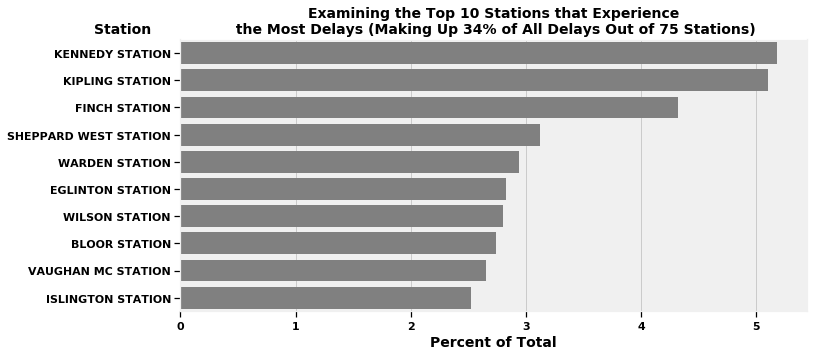

In [1061]:
plt.figure(figsize = (10,5))
sns.barplot(y = big_df.groupby([big_df['Date'].dt.year,'Station']).sum().groupby("Station").mean()['Count'].sort_values(ascending = False).index[0:10], x = big_df.groupby([big_df['Date'].dt.year,'Station']).sum().groupby("Station").mean()['Count'].sort_values(ascending = False).values[0:10]/yearly_delay_mean*100, color = "gray", orient = "h")
plt.xlabel("Percent of Total", fontsize = 14, weight = "bold")
plt.text(-0.75,-0.75, "Station", fontsize = 14, weight = "bold")
plt.ylabel("")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Top 10 Stations that Experience\n the Most Delays (Making Up 34% of All Delays Out of 75 Stations)", fontsize = 14, weight = "bold")
plt.savefig("Percent of delays by station")

How much of total yearly delays do these 10 stations make up? 

In [716]:
# determine total percentage from top 10 stations
(big_df.groupby([big_df['Date'].dt.year,'Station']).sum().groupby("Station").mean()['Count'].sort_values(ascending = False).values[0:10]/yearly_delay_mean*100).sum()


34.206719370996524

Why are there so many delays at Kennedy, Kipling and Finch Station? 

In [731]:
big_df[(big_df['Station'] == "KENNEDY STATION")| (big_df['Station'] == "KIPLING STATION") | (big_df['Station'] == "FINCH STATION")]['Code Description'].value_counts().head(10)

MISCELLANEOUS SPEED CONTROL                                 4329
OPERATOR OVERSPEEDING                                       2290
INJURED OR ILL CUSTOMER (IN STATION) - TRANSPORTED          1143
MISC. TRANSPORTATION OTHER - EMPLOYEE NON-CHARGEABLE         619
PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND      581
DISORDERLY PATRON                                            537
OPERATOR VIOLATED SIGNAL                                     518
BRAKES                                                       507
INJURED OR ILL CUSTOMER (ON TRAIN) - MEDICAL AID REFUSED     423
ESCALATOR/ELEVATOR INCIDENT                                  395
Name: Code Description, dtype: int64

Top 4 stations are terminal stations, which has been speculated before to be more prone to errors due to operator errors towards the beginning or end of their shifts, i.e. when trains are at
either the beginning or end of the line.
https://www.tellingstorieswithdata.com/inputs/pdfs/paper_one-2022-alyssa_schleifer.pdf

Which direction is more prone to delays? 

In [740]:
big_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code #,Vehicle Type,Code Description,Datetime,Hour,Count,Month
1,2014-01-01,02:06,2,HIGH PARK STATION,SUDP,3,7,W,BD,5001,105.0,SUB,DISORDERLY PATRON,2014-01-01 02:06:00-05:00,2,1,1
2,2014-01-01,03:10,2,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,105.0,SUB,DISORDERLY PATRON,2014-01-01 03:10:00-05:00,3,1,1
3,2014-01-01,03:20,2,BLOOR STATION,MUSAN,5,10,S,YU,5386,53.0,SUB,UNSANITARY VEHICLE,2014-01-01 03:20:00-05:00,3,1,1
4,2014-01-01,03:29,2,DUFFERIN STATION,MUPAA,0,0,E,BD,5174,48.0,SUB,PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROU...,2014-01-01 03:29:00-05:00,3,1,1
5,2014-01-01,08:48,2,KIPLING STATION,MUNOA,5,0,E,BD,0,45.0,SUB,NO OPERATOR IMMEDIATELY AVAILABLE - NOT E.S.A....,2014-01-01 08:48:00-05:00,8,1,1


In [755]:
yearly_delay_mean_bound = big_df.groupby([big_df['Date'].dt.year,'Bound']).sum().groupby("Bound").mean()['Count'].sum()

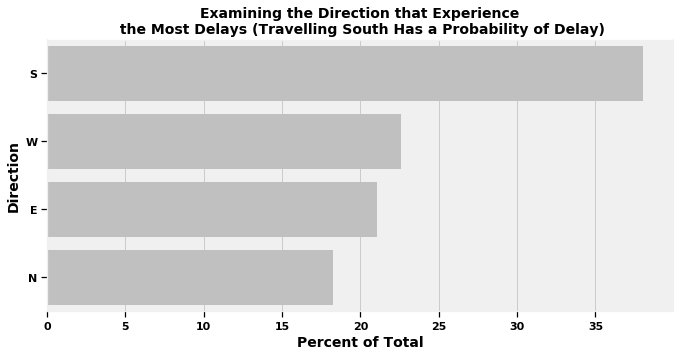

In [1050]:
plt.figure(figsize = (10,5))
sns.barplot(y = big_df.groupby([big_df['Date'].dt.year,'Bound']).sum().groupby("Bound").mean()['Count'].sort_values(ascending = False).index[0:10], x = big_df.groupby([big_df['Date'].dt.year,'Bound']).sum().groupby("Bound").mean()['Count'].sort_values(ascending = False).values[0:10]/yearly_delay_mean_bound*100, color = "silver", orient = "h")
plt.xlabel("Percent of Total", fontsize = 14, weight = "bold")
#plt.text(-5,1.5, "Direction", fontsize = 14, weight = "bold")
plt.ylabel("Direction", weight = "bold", fontsize = 14)
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Examining the Direction that Experience\n the Most Delays (Travelling South Has a Probability of Delay)", fontsize = 14, weight = "bold")
plt.savefig("Percent of delays by direction of train")

It is suspected that going Southbound has the highest percent of total delays since most people going downtown do not prefer to drive so they typically commute down

To support this claim, check what type of delays we have going southbound

In [833]:
big_df[big_df['Bound'] == "S"]['Code Description'].value_counts().head(10)

INJURED OR ILL CUSTOMER (IN STATION) - TRANSPORTED            7651
MISCELLANEOUS SPEED CONTROL                                   3807
ESCALATOR/ELEVATOR INCIDENT                                   3135
PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND       3064
OPERATOR OVERSPEEDING                                         2905
DISORDERLY PATRON                                             2479
INJURED OR ILL CUSTOMER (IN STATION) - MEDICAL AID REFUSED    1818
INJURED OR ILL CUSTOMER (ON TRAIN) - MEDICAL AID REFUSED      1345
MISCELLANEOUS OTHER                                           1248
STATION STAIRWAY INCIDENT                                     1129
Name: Code Description, dtype: int64

In [834]:
big_df[big_df['Bound'] == "N"]['Code Description'].value_counts().head(10)

PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND     3761
OPERATOR OVERSPEEDING                                       2748
MISCELLANEOUS SPEED CONTROL                                 2534
DISORDERLY PATRON                                           1459
INJURED OR ILL CUSTOMER (ON TRAIN) - MEDICAL AID REFUSED     893
OPERATOR VIOLATED SIGNAL                                     803
INJURED OR ILL CUSTOMER (IN STATION) - TRANSPORTED           763
ATC PROJECT                                                  566
SPEED CONTROL EQUIPMENT                                      423
PASSENGER OTHER                                              397
Name: Code Description, dtype: int64

The #1 Reason for delays going south bound is an injured or ill customers with twice as much occurence as the #1 for delays going North Bound

# Subway Delay Analysis

In [954]:
big_df['Min Delay'].describe()

count    115984.000000
mean          1.224462
std           1.984368
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max           7.000000
Name: Min Delay, dtype: float64

In [953]:
delay_df['Min Delay'].describe()

count    143917.000000
mean          2.197802
std           8.833085
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         999.000000
Name: Min Delay, dtype: float64

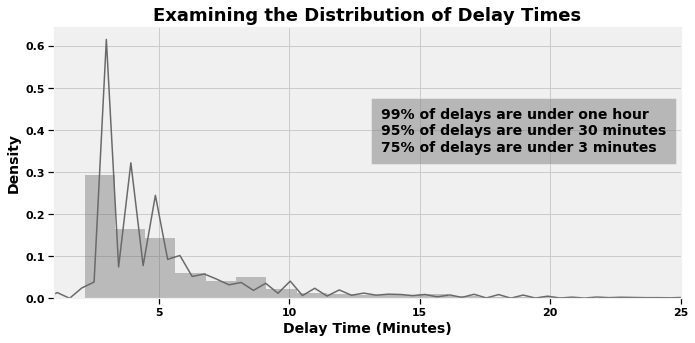

In [1005]:
# What is the distribution of subway delay times?  
plt.figure(figsize = (10,5))
plt.title("Examining the Distribution of Delay Times", fontsize =18, weight = "bold")
sns.distplot(delay_df[(delay_df['Min Delay']>0) & (delay_df['Min Delay']<60)]['Min Delay'], kde = True, color = "dimgray")
plt.xlim([1,25])
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.xlabel("Delay Time (Minutes)", fontsize = 14, weight = "bold")
plt.ylabel("Density", fontsize = 14, weight = "bold")
plt.text(13.5,0.35, "99% of delays are under one hour\n95% of delays are under 30 minutes\n75% of delays are under 3 minutes", fontsize = 14, weight = "bold", bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
plt.savefig("Distribution of Delay Times")

What types of subway delays are most common?

In [968]:
big_df['Code Description'].shape[0]

115984

In [1008]:
big_df['Code Description'].unique()

array(['DISORDERLY PATRON', 'UNSANITARY VEHICLE',
       'PASSENGER ASSISTANCE ALARM ACTIVATED - NO TROUBLE FOUND',
       'NO OPERATOR IMMEDIATELY AVAILABLE - NOT E.S.A. RELATED ',
       'OPERATOR OVERSPEEDING',
       'MISC. TRANSPORTATION OTHER - EMPLOYEE NON-CHARGEABLE',
       'MISCELLANEOUS SPEED CONTROL',
       'INJURED OR ILL CUSTOMER (ON TRAIN) - MEDICAL AID REFUSED',
       'PASSENGER OTHER',
       'INJURED OR ILL CUSTOMER (ON TRAIN) - TRANSPORTED',
       'FIRE/SMOKE PLAN B - SOURCE TTC', 'OPERATOR VIOLATED SIGNAL',
       'INSULATED JOINT RELATED PROBLEM', 'ESCALATOR/ELEVATOR INCIDENT',
       'ASSAULT / PATRON INVOLVED', 'DOOR PROBLEMS - FAULTY EQUIPMENT',
       'RAIL CARS & SHOPS OPR. ERROR', 'OPERATOR OVERSHOT PLATFORM',
       'DOOR PROBLEMS - DEBRIS RELATED',
       'NO OPERATOR IMMEDIATELY AVAILABLE ', 'PROPULSION SYSTEM',
       'ICE / SNOW RELATED PROBLEMS', 'OPERATOR NOT IN POSITION',
       'STATION STAIRWAY INCIDENT ',
       'SIGNALS OR RELATED COMPONENTS FA

In [1016]:
top_delays= ['OPERATOR SPEED CONTROL', 'ILL CUSTOMERS', 'PASSENGER ALARM', 'DISORDERLY PATRON', 'ESCALATOR/ELEVATOR INCIDENT']
subway_delay = [0,1,2,3,4]

In [1022]:
subway_delay

[0.28928128017657606,
 0.1383811560215202,
 0.08087322389295075,
 0.056861291212581044,
 0.028779831700924265]

In [1019]:
# add similar delays in top 10 to each other to create plot
subway_delay[0] = subway_delay_types.values[0] + subway_delay_types.values[1]
subway_delay[1] = subway_delay_types.values[2] + subway_delay_types.values[5] + subway_delay_types.values[8]
subway_delay[2] = subway_delay_types.values[3]
subway_delay[3] = subway_delay_types.values[4]
subway_delay[4] = subway_delay_types.values[6]

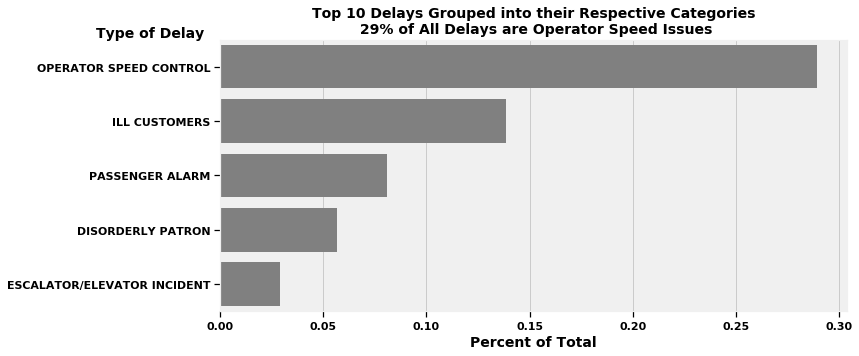

In [1083]:
plt.figure(figsize = (10,5))
sns.barplot(y = top_delays, x = subway_delay, color = "gray", orient = "h")
plt.xlabel("Percent of Total", fontsize = 14, weight = "bold")
plt.ylabel("")
plt.text(-0.06,-0.55, "Type of Delay", fontsize = 14, weight = "bold")
plt.yticks(weight = "bold")
plt.xticks(weight = "bold")
plt.title("Top 10 Delays Grouped into their Respective Categories\n 29% of All Delays are Operator Speed Issues", fontsize = 14, weight = "bold")
plt.savefig("Top types of delays")